Code to perform float clustering via hierarchical and kmeans

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
pd.set_option('display.max_columns', None)

In [3]:
#Read in dataframe
df = pd.read_csv("../../data/float_loc_data_new_vars.csv")
df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_ipar,sat_sst,sat_poc,sat_bbp_443,sat_a_678,sat_kd_490,sat_nflh,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [4]:
df.columns

Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [5]:
# cor = df.corr()
# cor[abs(cor)>.7]

In [6]:
# Focuse on specific columns: sat_chl, sat_bb_678, sat_bbp_443, sat_sst, sat_poc, sat_par, sat_aph_443, sat_pic, lat, lon,
# date, (BBP700, CHLA -> we may not want these because they come from the float)
df = df[['float', 'latitude', 'longitude', 'cycleNumber', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']]
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995


In [7]:
df['short_date']=pd.to_datetime(df['short_date'])

In [8]:
df['month'] = df['short_date'].apply(lambda x: x.month)

In [9]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [10]:
def get_season(row):
    '''
    Description: Function to extract season from dataframe using the latitude and month
        Southern and Northern hemisphere have differing seasons so this function uses
        a dictionary to correctly map the season for the row of data.
    Input: row of dataframe
    Output: season of the row
    '''
    if row['latitude'] <0:
        season = month_seasons_dict.get(row['month'])[1]
    else:
        season = month_seasons_dict.get(row['month'])[0]
    return(season)

In [11]:
#Add column for seasonality
df['seasonality'] = df.apply(get_season, axis=1)

In [12]:
# Need to normalize the values across the PRES before performing transform and clustering
from sklearn.preprocessing import MinMaxScaler
cols= ['PSAL','TEMP', 'BBP700', 'CHLA', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']
norm_cols = ['norm_'+col for col in cols]
#Transform all columns by min-max scaler, when min=max then the denominator is just max and don't subtract min
df[norm_cols] = df.groupby(['float','cycleNumber'])[cols].transform(lambda x: (x-x.min())/(x.max()-x.min()) if x.max() != x.min() \
       else (x)/(x.max()))
# MinMaxScaler().fit_transform(x))
# (x-x.min())/(x.max()-x.min()))
#remove old columns
# df = df.drop(cols, axis=1)
# lambda x: (x-x.mean())/x.std())
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df[(df['float'] == 1902303)&(df['cycleNumber']==1)]['sat_chl'].describe()

count    523.000000
mean       0.370203
std        0.000000
min        0.370203
25%        0.370203
50%        0.370203
75%        0.370203
max        0.370203
Name: sat_chl, dtype: float64

In [13]:
#Bin the PRES values in segments of 10
num_bins = 100
labels = list(range(1,num_bins+1))
bins = list(np.arange(0, 1010, 10))
df['PRES_binned'] = pd.cut(df['PRES'],bins=bins, labels=labels)

In [16]:
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678,PRES_binned
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [17]:
smaller_df = df[['float','latitude','longitude','seasonality','PRES_binned','norm_sat_chl']]
# smaller_df['PRES_binned'] = smaller_df['PRES_binned'].apply(str)
smaller_df.head()

,float,latitude,longitude,seasonality,PRES_binned,norm_sat_chl
0,1902303,49.236,-14.742,2,1,1.0
1,1902303,49.236,-14.742,2,1,1.0
2,1902303,49.236,-14.742,2,1,1.0
3,1902303,49.236,-14.742,2,1,1.0
4,1902303,49.236,-14.742,2,1,1.0


In [19]:
smaller_df = smaller_df.head(10000)

In [21]:
df.shape

(33210617, 33)

In [20]:
pivoted = pd.pivot_table(data=smaller_df,columns='PRES_binned',values='norm_sat_chl', aggfunc='mean', index=['float','latitude','longitude','seasonality'])
pivoted.head()


PRES_binned                               1    2    3    4    5    6    7  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                               8    9   10   11   12   13   14  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              15   16   17   18   19   20   21  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              22   23   24   25   26   27   28  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              29   30   31   32   33   34   35  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              36   37   38   39   40   41   42  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              43   44   45   46   47   48   49  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.781   -14.675   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.843   -14.764   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.890   -14.856   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        47.954   -14.903   2            1.0  1.0  1.0  1.0  1.0  1.0  1.0   

PRES_binned                              50   51   52   53   54   55   56  \
float   latitude longitude seasonality                                      
1902303 47.709   -14.627   2            1.0  1.0  1.0  NaN  NaN  N

In [137]:
pivoted = df[['float','PRES_binned','CHLA']].pivot(columns='PRES_binned',values='CHLA')
pivoted.head()

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_4627/2946206693.py:1: PerformanceWarning: The following operation may generate 3354272317 cells in the resulting pandas object.
  pivoted = df[['float','PRES_binned','CHLA']].pivot(columns='PRES_binned',values='CHLA')


: 

: 

In [22]:
#CONFIRMATION IT WORKED
test_df = df[df['float']==1902303]

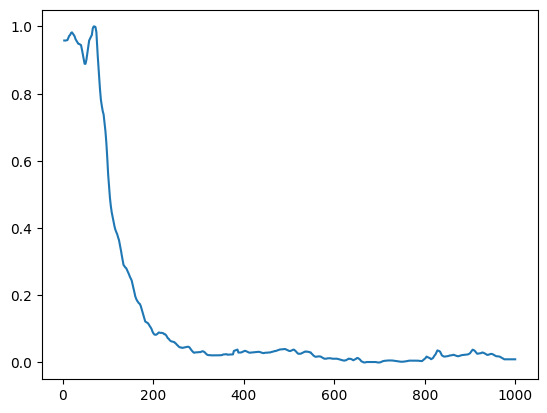

In [23]:
for cycle in test_df['cycleNumber'].unique()[0:1]:
    test_df_cycle = test_df[test_df['cycleNumber']==cycle]
    plt.plot(test_df_cycle['PRES'], test_df_cycle['norm_BBP700'])
    # plt.plot(test_df_cycle['PRES'], test_df_cycle['BBP700'])
    plt.show()

In [25]:
test_df_cycle['longitude'].unique()

array([-14.742])

In [ ]:
df_pivot = df.pivot(index= )

In [22]:
df['PRES'].describe()

count    3.321062e+07
mean     4.326551e+02
std      2.898966e+02
min      0.000000e+00
25%      1.780000e+02
50%      3.880000e+02
75%      6.820000e+02
max      1.008000e+03
Name: PRES, dtype: float64

In [ ]:
# Need to convert the cycle for each float to a single row
# Need to normalize the values across the PRES

# Curve Fitting
## Parametric

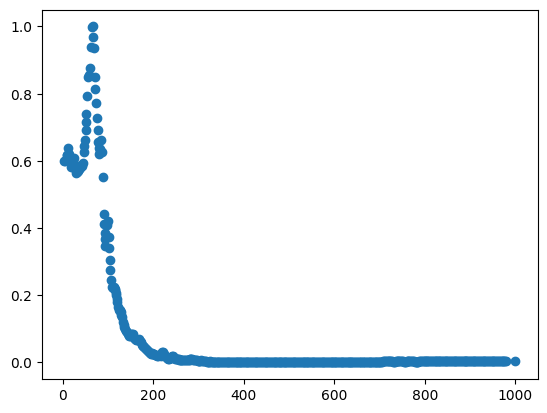

In [26]:
# Curve fitting
fit_df = df[(df['float']==1902303)&(df['cycleNumber']==1)]
xdata = np.asarray(fit_df['PRES'])
ydata = np.asarray(fit_df['norm_CHLA'])
plt.plot(xdata, ydata, 'o')

In [30]:
from fitter import Fitter, get_common_distributions, get_distributions

In [120]:
# def objective(x, a, b, c):
# 	return a * x + b
# # define the true objective function
# def objective_square(x, a, b, c):
# 	return a * x + b * x**2 + c
# define the true objective function
def objective(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
# define the true objective function
# def objective(x, a, b, c, d):
# 	return a * np.sin(b - x) + c * x**2 + d
def objective(x, a, b, c,d):
	return a*np.exp(-b*x) + c*np.exp(-d*x) 
 

0.44624487963314174 0.010238433218933227 0.46716880051519416 0.010238023346584676


/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_4627/3684549979.py:13: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x) + c*np.exp(-d*x)
/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_4627/3684549979.py:13: RuntimeWarning: invalid value encountered in add
  return a*np.exp(-b*x) + c*np.exp(-d*x)


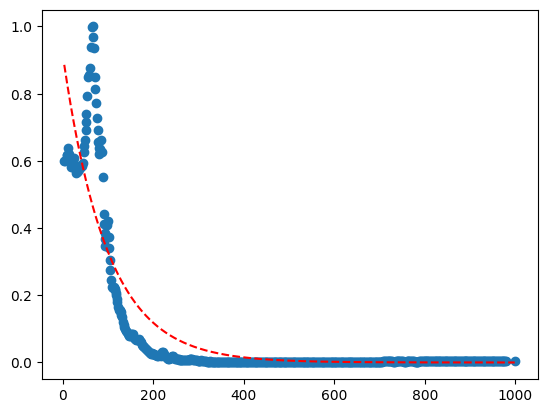

In [121]:
popt, _ = curve_fit(objective, xdata, ydata)
# summarize the parameter values
a, b, c, d = popt
print(a, b, c, d)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(xdata), max(xdata), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
plt.scatter(xdata, ydata)
plt.plot(x_line, y_line, '--', color='red')

In [103]:
mymodel = np.poly1d(np.polyfit(xdata, ydata, 100))

/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


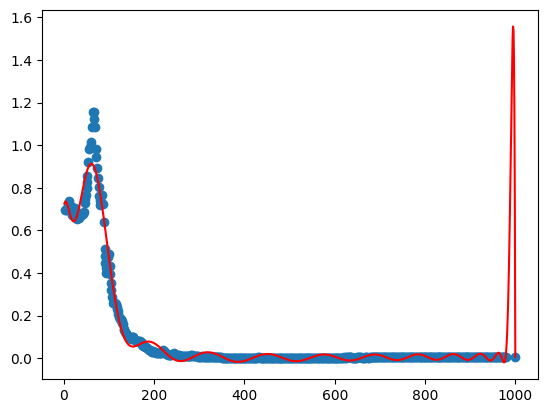

In [104]:
myline = np.linspace(1, 1000, 1000)
plt.scatter(xdata, ydata)
plt.plot(myline, mymodel(myline),color='red')

## Lowess Smoothing
A non-parametric approach to fitting data to a curve

In [27]:
import statsmodels.api as sm

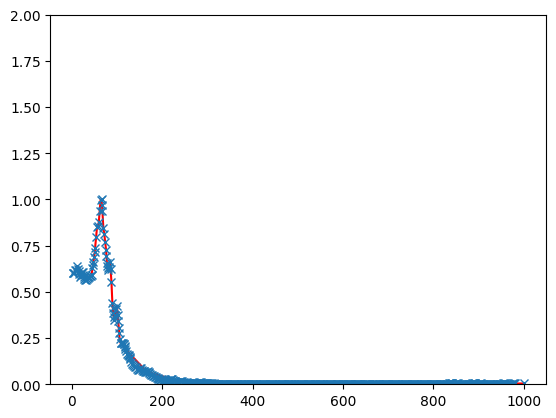

In [56]:
lowess = sm.nonparametric.lowess
z = lowess(ydata, xdata, frac=1/8)
# z1 = lowess(ydata, xdata, frac=1/7)
# _ = plt.plot(xdata, ydata)
_ = plt.plot(xdata, z, color='red')
# _ = plt.plot(xdata, z1, color='green')
_ = plt.ylim([0,2])
_ = plt.plot(xdata, ydata,'x')
